In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI Model Garden - Stable Diffusion V1.5

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_pytorch_stable_diffusion.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_pytorch_stable_diffusion.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/community/model_garden/model_garden_pytorch_stable_diffusion.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
Open in Vertex AI Workbench
    </a>
    (a Python-3 GPU notebook with preinstalled HuggingFace/transformer libraries is recommended)
  </td>
</table>

## Overview

This notebook demonstrates running local inference for [runwayml/stable-diffusion-v1-5](https://huggingface.co/runwayml/stable-diffusion-v1-5) on either [Colab](https://colab.research.google.com) or [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench). This notebook also demonstrates finetuning runwayml/stable-diffusion-v1-5 with [Dreambooth](https://huggingface.co/docs/diffusers/training/dreambooth) and deploying it on Vertex AI for online prediction.

### Objective

- Run local predictions for text-to-image and text-guided-image-to-image with serving dockers.
- Finetune the stable-diffusion-v1.5 model with [Dreambooth](https://huggingface.co/docs/diffusers/training/dreambooth).
- Upload the model to [Vertex AI Model Registry](https://cloud.google.com/vertex-ai/docs/model-registry/introduction).
- Deploy the model to a [Vertex AI Endpoint resource](https://cloud.google.com/vertex-ai/docs/predictions/using-private-endpoints).
- Run online predictions for text-to-image and text-guided-image-to-image.

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage pricing](https://cloud.google.com/storage/pricing), and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Before you begin

**NOTE**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

### Setup notebook

#### Colab only
Run the following commands for Colab and skip this section if you are using Workbench.

In [ ]:

%pip install --upgrade google-cloud-aiplatform
%pip install --upgrade pip
%pip install torchvision==0.14.1
%pip install transformers==4.27.1
%pip install diffusers==0.15.1
%pip install datasets==2.9.0
%pip install accelerate==0.18.0
%pip install triton==2.0.0.dev20221120
%pip install xformers==0.0.16
    # Install gdown for downloading example training images.
%pip install gdown
    # Remove wrong cublas version.
%pip uninstall nvidia_cublas_cu11 --yes

    # Restart the notebook kernel after installs.
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

#### Workbench only
1.   Follow [this link](https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/community/model_garden/model_garden_pytorch_stable_diffusion_inpainting.ipynb) to deploy the notebook to a Vertex AI Workbench Instance.
2.   Select `Create a new Notebook`.
3.   Click `Advanced Options`.
4.   Under **Environment**, select `Custom Container` for `Environment`.
5.   Set `Docker container image` to `us-docker.pkg.dev/vertex-ai/vertex-vision-model-garden-dockers/transformers-notebook`.
6.   Under **Machine configuration**, select 1 `T4` GPU and select `Install NVIDIA GPU driver automatically for me`.
7.   Click `Create` to create the Vertex AI Workbench instance.

### Setup Google Cloud project

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable the Vertex AI API and Compute Engine API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com,compute_component).

1. [Create a Cloud Storage bucket](https://cloud.google.com/storage/docs/creating-buckets) for storing experiment outputs.

1. [Create a service account](https://cloud.google.com/iam/docs/service-accounts-create#iam-service-accounts-create-console) with `Vertex AI User` and `Storage Object Admin` roles for deploying fine tuned model to Vertex AI endpoint.

Fill following variables for experiments environment:

In [5]:
# Cloud project id.
PROJECT_ID = "google.com:ml-baguette-demos"  # @param {type:"string"}

# The region you want to launch jobs in.
REGION = "us-central1"  # @param {type:"string"}

# The Cloud Storage bucket for storing experiments output. Fill it without the 'gs://' prefix.
GCS_BUCKET = "gs://julienmiquel-cloud/stable-diffusion/output"  # @param {type:"string"}

# The service account for deploying fine tuned model.
SERVICE_ACCOUNT = "genai-julienmiquel@ml-baguette-demos.google.com.iam.gserviceaccount.com"  # @param {type:"string"}

Initialize Vertex-AI API:

In [6]:
from google.cloud import aiplatform

aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=GCS_BUCKET)

### Define constants

In [7]:
# The pre-built training docker image. It contains training scripts and models.
TRAIN_DOCKER_URI = "us-docker.pkg.dev/vertex-ai-restricted/vertex-vision-model-garden-dockers/pytorch-diffusers-train:latest"

# The pre-built serving docker image. It contains serving scripts and models.
SERVE_DOCKER_URI = "us-docker.pkg.dev/vertex-ai-restricted/vertex-vision-model-garden-dockers/pytorch-diffusers-serve"

### Define common functions

In [8]:
import base64
import glob
import os
from datetime import datetime
from io import BytesIO

import requests
import torch
from google.cloud import aiplatform, storage
from PIL import Image


def create_job_name(prefix):
    user = os.environ.get("USER")
    now = datetime.now().strftime("%Y%m%d_%H%M%S")
    job_name = f"{prefix}-{user}-{now}"
    return job_name


def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content))


def image_to_base64(image, format="JPEG"):
    buffer = BytesIO()
    image.save(buffer, format=format)
    image_str = base64.b64encode(buffer.getvalue()).decode("utf-8")
    return image_str


def base64_to_image(image_str):
    image = Image.open(BytesIO(base64.b64decode(image_str)))
    return image


def image_grid(imgs, rows=2, cols=2):
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid


def deploy_model(model_id, task):
    model_name = "stable-diffusion-v1"
    endpoint = aiplatform.Endpoint.create(display_name=f"{model_name}-{task}-endpoint")
    serving_env = {
        "MODEL_ID": model_id,
        "TASK": task,
    }
    model = aiplatform.Model.upload(
        display_name=model_name,
        serving_container_image_uri=SERVE_DOCKER_URI,
        serving_container_ports=[7080],
        serving_container_predict_route="/predictions/diffusers_serving",
        serving_container_health_route="/ping",
        serving_container_environment_variables=serving_env,
    )
    model.deploy(
        endpoint=endpoint,
        machine_type="n1-standard-8",
        accelerator_type="NVIDIA_TESLA_V100",
        accelerator_count=1,
        deploy_request_timeout=1800,
        service_account=SERVICE_ACCOUNT,
    )
    return model, endpoint


def get_bucket_and_blob_name(filepath):
    # The gcs path is of the form gs://<bucket-name>/<blob-name>
    gs_suffix = filepath.split("gs://", 1)[1]
    return tuple(gs_suffix.split("/", 1))


def upload_local_dir_to_gcs(local_dir_path, gcs_dir_path):
    """Uploads files in a local directory to a GCS directory."""
    client = storage.Client()
    bucket_name = gcs_dir_path.split("/")[2]
    bucket = client.get_bucket(bucket_name)
    for local_file in glob.glob(local_dir_path + "/**"):
        if not os.path.isfile(local_file):
            continue
        filename = local_file[1 + len(local_dir_path) :]
        gcs_file_path = os.path.join(gcs_dir_path, filename)
        _, blob_name = get_bucket_and_blob_name(gcs_file_path)
        blob = bucket.blob(blob_name)
        blob.upload_from_filename(local_file)
        print("Copied {} to {}.".format(local_file, gcs_file_path))

## Run inferences locally

### Text-to-image

In [6]:
from diffusers import StableDiffusionPipeline

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

prompt = "a photo of an astronaut riding a horse on mars"
image = pipe(prompt).images[0]

display(image)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 5>:5                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_utils.py:643 in to          │
│                                                                                                  │
│    640 │   │                                                                                     │
│    641 │   │   is_offloaded = pipeline_is_offloaded or pipeline_is_sequentially_offloaded        │
│    642 │   │   for module in modules:                                                            │
│ ❱  643 │   │   │   module.to(torch_device, torch_dtype)                                          │
│    644 │   │   │   if (                                                                          │
│    645 │   │   │   │   module.dtype == torch.float16                                             │
│    646 │   │   │   │   and str(torch_device) in ["cpu"]                                          │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:989 in to                     │
│                                                                                                  │
│    986 │   │   │   │   │   │   │   non_blocking, memory_format=convert_to_format)                │
│    987 │   │   │   return t.to(device, dtype if t.is_floating_point() or t.is_complex() else No  │
│    988 │   │                                                                                     │
│ ❱  989 │   │   return self._apply(convert)                                                       │
│    990 │                                                                                         │
│    991 │   def register_backward_hook(                                                           │
│    992 │   │   self, hook: Callable[['Module', _grad_t, _grad_t], Union[None, Tensor]]           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:641 in _apply                 │
│                                                                                                  │
│    638 │                                                                                         │
│    639 │   def _apply(self, fn):                                                                 │
│    640 │   │   for module in self.children():                                                    │
│ ❱  641 │   │   │   module._apply(fn)                                                             │
│    642 │   │                                                                                     │
│    643 │   │   def compute_should_use_set_data(tensor, tensor_applied):                          │
│    644 │   │   │   if torch._has_compatible_shallow_copy_type(tensor, tensor_applied):           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:664 in _apply                 │
│                                                                                                  │
│    661 │   │   │   # track autograd history of `param_applied`, so we have to use                │
│    662 │   │   │   # `with torch.no_grad():`                                                     │
│    663 │   │   │   with torch.no_grad():                                                         │
│ ❱  664 │   │   │   │   param_applied = fn(param)                                                 │
│    665 │   │   │   should_use_set_data = compute_should_use

### Text-guided image-to-image

In [ ]:
from diffusers import StableDiffusionImg2ImgPipeline

device = "cuda"
model_id_or_path = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_id_or_path, torch_dtype=torch.float16
)
pipe = pipe.to(device)

url = "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg"

response = requests.get(url)
init_image = Image.open(BytesIO(response.content)).convert("RGB")
init_image = init_image.resize((768, 512))

prompt = "A fantasy landscape, trending on artstation"

images = pipe(prompt=prompt, image=init_image, strength=0.75, guidance_scale=7.5).images
display(images[0])

## Finetune with Dreambooth

This section uses [dreambooth](https://dreambooth.github.io/) to finetune the [stable-diffusion-v1.5](https://huggingface.co/runwayml/stable-diffusion-v1-5) model with [5 dog images](https://drive.google.com/drive/folders/1BO_dyz-p65qhBRRMRA4TbZ8qW4rB99JZ) to personalize the text-to-image model.

It finetunes both text encoder and unet of the stable diffusion model up to 800 steps. The whole finetuning job takes 30 minutes to finish using 1 A100 GPU.

The full model will be saved after the finetuning job finishs and it can be loaded by the [StableDiffusionPipeline](https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/text2img) to run inference.

In [ ]:
# Download example training images.
!gdown --folder https://drive.google.com/drive/folders/1BO_dyz-p65qhBRRMRA4TbZ8qW4rB99JZ

# Upload data to Cloud Storage bucket.
upload_local_dir_to_gcs("dog", f"gs://{GCS_BUCKET}/dreambooth/dog")
upload_local_dir_to_gcs("dog", f"gs://{GCS_BUCKET}/dreambooth/dog_class")

**NOTE**: If the upload step fails due to lacking of permission, you need to [grant the Storage Object Admin role](https://cloud.google.com/storage/docs/access-control/using-iam-permissions) for the Cloud account of the notebook.

In [ ]:
# The pre-trained model to be loaded.
model_id = "runwayml/stable-diffusion-v1-5"

# Input and output path.
instance_dir = f"/gcs/{GCS_BUCKET}/dreambooth/dog"
class_dir = f"/gcs/{GCS_BUCKET}/dreambooth/dog_class"
output_dir = f"/gcs/{GCS_BUCKET}/dreambooth/output"

# Worker pool spec.
machine_type = "a2-highgpu-1g"
num_nodes = 1
gpu_type = "NVIDIA_TESLA_A100"
num_gpus = 1

# Setup training job.
job_name = create_job_name("dreambooth-stable-diffusion")
job = aiplatform.CustomContainerTrainingJob(
    display_name=job_name,
    container_uri=TRAIN_DOCKER_URI,
)

# Pass training arguments and launch job.
# See https://github.com/huggingface/diffusers/blob/v0.14.0/examples/dreambooth/train_dreambooth.py#L75
# for a full list of training arguments.
model = job.run(
    args=[
        "dreambooth/train_dreambooth.py",
        f"--pretrained_model_name_or_path={model_id}",
        "--train_text_encoder",
        f"--instance_data_dir={instance_dir}",
        f"--class_data_dir={class_dir}",
        f"--output_dir={output_dir}",
        "--with_prior_preservation",
        "--prior_loss_weight=1.0",
        "--instance_prompt='a photo of sks dog'",
        "--class_prompt='a photo of dog'",
        "--resolution=512",
        "--train_batch_size=1",
        "--gradient_checkpointing",
        "--learning_rate=2e-6",
        "--lr_scheduler=constant",
        "--lr_warmup_steps=0",
        "--num_class_images=200",
        "--max_train_steps=800",
    ],
    replica_count=num_nodes,
    machine_type=machine_type,
    accelerator_type=gpu_type,
    accelerator_count=num_gpus,
)

## Upload and Deploy models

This section uploads the model to Model Registry and deploys it on the Endpoint.

The model deployment step will take ~15 minutes to complete.

### Text-to-image

Deploy the stable diffusion model for the text-to-image task.

Once deployed, you can send a batch of text prompts to the endpoint to generated images.

When deployed on one V100 GPU, the averaged inference time of a request is ~15 seconds.

In [ ]:
# Set the model_id to "runwayml/stable-diffusion-v1-5" to load the OSS pre-trained model.
model, endpoint = deploy_model(
    model_id=f"gs://{GCS_BUCKET}/dreambooth/output", task="text-to-image"
)

NOTE: The model weights will be downloaded after the deployment succeeds. Thus additional 5 minutes of waiting time is needed **after** the above model deployment step succeeds and before you run the next step below. Otherwise you might see a `ServiceUnavailable: 503 502:Bad Gateway` error when you send requests to the endpoint.

In [ ]:
instances = [
    {"prompt": "a squirrel in Picasso style"},
    {"prompt": "a dog in Picasso style"},
    {"prompt": "a cat in Picasso style"},
    {"prompt": "a deer in Picasso style"},
]
response = endpoint.predict(instances=instances)
images = [base64_to_image(image) for image in response.predictions]
image_grid(images)

Clean up resources:

In [ ]:
# Undeploy model and delete endpoint.
endpoint.delete(force=True)

# Delete models.
model.delete()

### Text-guided image-to-image

Deploy the stable diffusion model for the text-guided image-to-image task.

In [9]:
# Set the model_id to a GCS path, like "gs://GCS_BUCKET/dreambooth/output", to load the dreambooth finetuned model above.
model, endpoint = deploy_model(
    model_id="runwayml/stable-diffusion-v1-5", task="image-to-image"
)

Creating Endpoint
Create Endpoint backing LRO: projects/660199673046/locations/us-central1/endpoints/7168213280727498752/operations/5749977627473477632
Endpoint created. Resource name: projects/660199673046/locations/us-central1/endpoints/7168213280727498752
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/660199673046/locations/us-central1/endpoints/7168213280727498752')
Creating Model
Create Model backing LRO: projects/660199673046/locations/us-central1/models/6974081308704112640/operations/8654799387127447552
Model created. Resource name: projects/660199673046/locations/us-central1/models/6974081308704112640@1
To use this Model in another session:
model = aiplatform.Model('projects/660199673046/locations/us-central1/models/6974081308704112640@1')
Deploying model to Endpoint : projects/660199673046/locations/us-central1/endpoints/7168213280727498752
Deploy Endpoint model backing LRO: projects/660199673046/locations/us-central1/endpoints/71682132807274

NOTE: The model weights will be downloaded after the deployment succeeds. Thus additional 5 minutes of waiting time is needed **after** the above model deployment step succeeds and before you run the next step below. Otherwise you might see a `ServiceUnavailable: 503 502:Bad Gateway` error when you send requests to the endpoint.

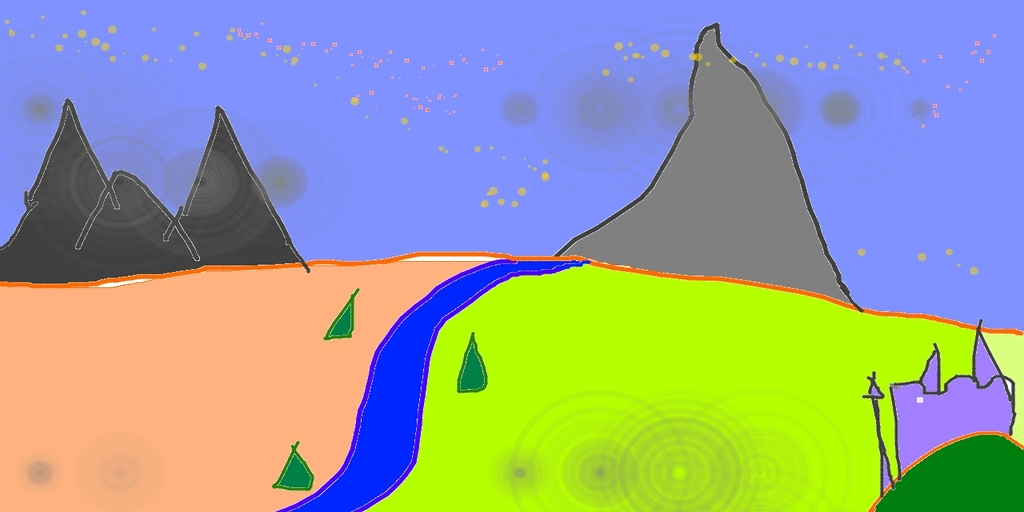

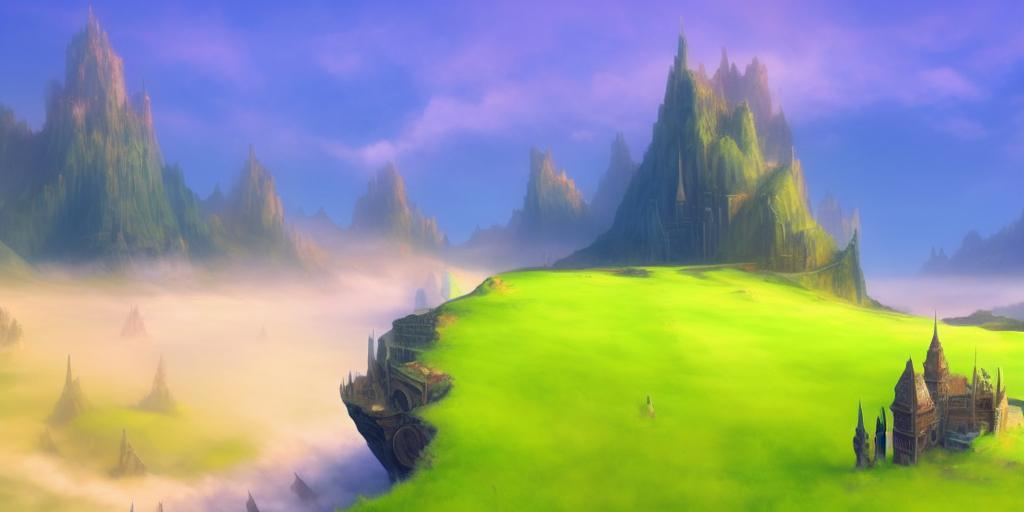

In [11]:
init_image = download_image(
    "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg"
)
display(init_image)
instances = [
    {
        "prompt": "A fantasy landscape, trending on artstation",
        "image": image_to_base64(init_image),
    },
]
response = endpoint.predict(instances=instances)
images = [base64_to_image(image) for image in response.predictions]
display(images[0])

Clean up resources:

In [ ]:
# Undeploy model and delete endpoint.
endpoint.delete(force=True)

# Delete models.
model.delete()